In [337]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import figure
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import cv2
from PIL import Image
from time import perf_counter
from collections import Counter

In [338]:
filter_x_prewitt = np.array([
    [-1, 0, 1], 
    [-1, 0, 1], 
    [-1, 0, 1]])
filter_y_prewitt = np.array([
    [-1, -1, -1], 
    [0, 0, 0], 
    [1, 1, 1]])
filter_x_sobel = np.array([
    [-1, 0, 1], 
    [-2, 0, 2], 
    [-1, 0, 1]])
filter_y_sobel = np.array([
    [-1, -2, -1], 
    [0, 0, 0], 
    [1, 2, 1]])
filter_diagonal_x = np.array([
    [0, 1],
    [-1, 0]
])
filter_gauss = np.array([
    [1, 4, 6, 4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4, 6, 4, 1],
])
filter_mexican_hat = np.array([
    [0, 0, -1, 0, 0],
    [0, -1, -8, -1, 0],
    [-1, -8, 32, -8, -1],
    [0, -1, -8, -1, 0],
    [0, 0, -1, 0, 0],
])
class Cadence():
    def __init__(self, path):
        self.path = path # path of .npy file
        self.cadence = np.load(self.path)
        self.cadence_f32 = self.cadence.astype(np.float32)
        self.cadence_transformed = np.load(path)
        self.cadence_transformed_f32 = self.cadence_transformed.astype(np.float32)
        self.vmin = 0
        self.vmax = 255
        self.mapped_to_grayscale = False

    def plot_cadence_for_comparing_differences(self, plot_gray=False) -> None:
        cmap = "gray" if plot_gray else None
        fig = plt.figure(figsize=(40,15))
        gs = GridSpec(2, 6) 
        num_imgs = self.cadence_f32.shape[0]
        for location, on_target in zip(range(int(num_imgs / 2)), range(0, num_imgs, 2)):
            ax = fig.add_subplot(gs[0, location * 2])
            ax.imshow(self.cadence_f32[on_target], cmap=cmap)
            ax.set_title("ON TARGET ORIGINAL")
        for location, on_target in zip(range(int(num_imgs / 2)), range(0, num_imgs, 2)):
            ax = fig.add_subplot(gs[0, location * 2 + 1])
            if self.mapped_to_grayscale:
                ax.imshow(self.cadence_transformed_f32[on_target], cmap=cmap, vmin=self.vmin, vmax=self.vmax)
            else:
                ax.imshow(self.cadence_transformed_f32[on_target], cmap=cmap)
            ax.set_title("ON TARGET TRANSFORMED")
        for location, off_target in zip(range(int(num_imgs / 2)), range(1, num_imgs, 2)):
            ax = fig.add_subplot(gs[1, location * 2])
            ax.imshow(self.cadence_f32[off_target], cmap=cmap)
            ax.set_title("OFF TARGET ORIGINAL")
        for location, off_target in zip(range(int(num_imgs / 2)), range(1, num_imgs, 2)):
            ax = fig.add_subplot(gs[1, location * 2 + 1])
            if self.mapped_to_grayscale:
                ax.imshow(self.cadence_transformed_f32[off_target], cmap=cmap, vmin = self.vmin, vmax = self.vmax)
            else:
                ax.imshow(self.cadence_transformed_f32[off_target], cmap=cmap)
            ax.set_title("OFF TARGET TRANSFORMED")
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

    def add_0_border(self, to_add):
        new_cadence_transformed = np.zeros(shape=(self.cadence_transformed_f32.shape[0], self.cadence_transformed_f32.shape[1] + 2*to_add, self.cadence_transformed_f32.shape[2] + 2*to_add))
        for image in range(new_cadence_transformed.shape[0]):
            new_cadence_transformed[image] = np.pad(self.cadence_transformed_f32[image], pad_width=to_add, mode='constant', constant_values=0)
        return new_cadence_transformed

    def convolution_filter(self, kernel):
        kernel_size = len(kernel)
        to_add = math.ceil(kernel_size / 2) - 1
        new_cadence_transformed = self.add_0_border(to_add)
        images = new_cadence_transformed.shape[0]
        rows = new_cadence_transformed.shape[1]
        cols = new_cadence_transformed.shape[2]

        for image in range(images):
            for i in range(rows - 2*to_add):
                for j in range(cols - 2*to_add):
                    current = new_cadence_transformed[image][i:i+kernel_size, j:j+kernel_size]
                    multiplication = sum(sum(current * kernel))
                    self.cadence_transformed_f32[image][i, j] = multiplication

    def set_nones_to_noise(self, use_average=True):
        num_images = self.cadence_transformed_f32.shape[0]
        num_rows = self.cadence_transformed_f32.shape[1]
        num_cols = self.cadence_transformed_f32.shape[2]
        cadence_transformed_deep_copy = np.copy(self.cadence_transformed_f32)
        # set None pixels to average noise around pixel
        for image in range(num_images):
            for row in range(num_rows):
                for col in range(num_cols):
                    if np.isnan(self.cadence_transformed_f32[image][row][col]):
                        set_noise = False
                        noise_search_size = 1
                        safe_row_start = row
                        safe_col_start = col
                        safe_row_end = row
                        safe_col_end = col
                        while not set_noise:
                            row_start = row - noise_search_size if row - noise_search_size >= 0 else safe_row_start
                            col_start = col - noise_search_size if col - noise_search_size >= 0 else safe_col_start
                            row_end = row + noise_search_size if row + noise_search_size < num_rows else safe_row_end
                            col_end = col + noise_search_size if col + noise_search_size < num_cols else safe_col_end

                            safe_row_start = row_start
                            safe_col_start = col_start
                            safe_row_end = row_end
                            safe_col_end = col_end

                            current_noise_filter = self.cadence_transformed_f32[image][row_start:row_end, col_start:col_end]
                            num_nones = np.count_nonzero(np.isnan(current_noise_filter))
                            noise_search_filter_size = current_noise_filter.size
                            max_num_nones = math.ceil(noise_search_filter_size) / 2
                            if use_average:
                                noise = np.nanmean(current_noise_filter)
                            else:
                                noise = Counter(np.reshape(current_noise_filter, current_noise_filter.size)).most_common(1)[0][0]
                            if (num_nones < max_num_nones or noise_search_filter_size >= num_rows * num_cols) and not np.isnan(noise):
                                cadence_transformed_deep_copy[image][row][col] = noise # probably median is better
                                set_noise = True
                            else:
                                noise_search_size += 1
        self.cadence_transformed_f32 = cadence_transformed_deep_copy

    def unify_similar_pixels(self, epsilon):
        num_images = self.cadence_transformed_f32.shape[0]
        num_rows = self.cadence_transformed_f32.shape[1]
        num_cols = self.cadence_transformed_f32.shape[2]
        epsilon = epsilon / 100 # => epsilon is given in percentage
        kernel_size = 2
        cadence_transformed_deep_copy = np.copy(self.cadence_transformed_f32)
        for image in np.arange(num_images):
            image_min = np.amin(self.cadence_transformed_f32[image])
            image_max = np.amax(self.cadence_transformed_f32[image])
            image_full_difference = image_max - image_min
            epsilon_cur_img = epsilon * image_full_difference
            for row in np.arange(num_rows - 1):
                for col in np.arange(num_cols - 1):
                    filter = self.cadence_transformed_f32[image][row:row+kernel_size, col:col+kernel_size]
                    current_pixel = self.cadence_transformed_f32[image][row][col]
                    for kernel_row in np.arange(0, kernel_size):
                        for kernel_col in np.arange(0, kernel_size):
                            possible_similar_pixel = filter[kernel_row][kernel_col]
                            if abs(possible_similar_pixel - current_pixel) <= epsilon_cur_img:
                                cadence_transformed_deep_copy[image][row + kernel_row][col + kernel_col] = cadence_transformed_deep_copy[image][row][col]
        self.cadence_transformed_f32 = cadence_transformed_deep_copy

    def map_to_proportional_colorscale(self, max=1024, min=0) -> None:
        colorscale_full_difference = abs(max - min)
        num_images = self.cadence_transformed_f32.shape[0]

        # occurrences_border = 1
        # for image in range(num_images):
        #     unique_values = np.unique(self.cadence_transformed_f32[image])
        #     for unique_value in unique_values:
        #         if np.count_nonzero(self.cadence_transformed_f32[image][self.cadence_transformed_f32[image] == unique_value]) <= occurrences_border:
        #             self.cadence_transformed_f32[image][self.cadence_transformed_f32[image] == unique_value] = None
        # # self.plot_cadence(True)
        # self.set_nones_to_noise(False)

        for image in range(num_images):
            unique_values = np.unique(self.cadence_transformed_f32[image])
            num_unique_values = len(unique_values)
            distance_between = colorscale_full_difference / num_unique_values
            for index, unique_value in enumerate(unique_values):
                self.cadence_transformed_f32[image][self.cadence_transformed_f32[image] == unique_value] = distance_between * index

    def map_similar_to_one(self, max=1024, min=0, similarity=0.05):
        colorscale_full_difference = abs(max - min)
        num_images = self.cadence_transformed_f32.shape[0]
        for image in range(num_images):
            unique_values = np.unique(self.cadence_transformed_f32[image])
            num_unique_values = len(unique_values)
            distance_between = colorscale_full_difference / num_unique_values
            is_similar = distance_between * similarity
            while len(unique_values) != 0:
                unique_value = unique_values[0]
                self.cadence_transformed_f32[image][np.logical_and(
                    self.cadence_transformed_f32[image] <= unique_value + is_similar,
                    self.cadence_transformed_f32[image] >= unique_value - is_similar
                )] = unique_value
                unique_values = np.delete(unique_values, np.where(np.logical_and(
                    unique_values <= unique_value + is_similar,
                    unique_values >= unique_value - is_similar
                )))


gauss:  2.4599999960628338e-05
unify:  2.009999934671214e-05
mapsimilartoone:  0.19194920000063576
proportionalscale:  0.06930779999947845
sobel:  2.6779512000002796
gauss2:  2.9400000130408444e-05


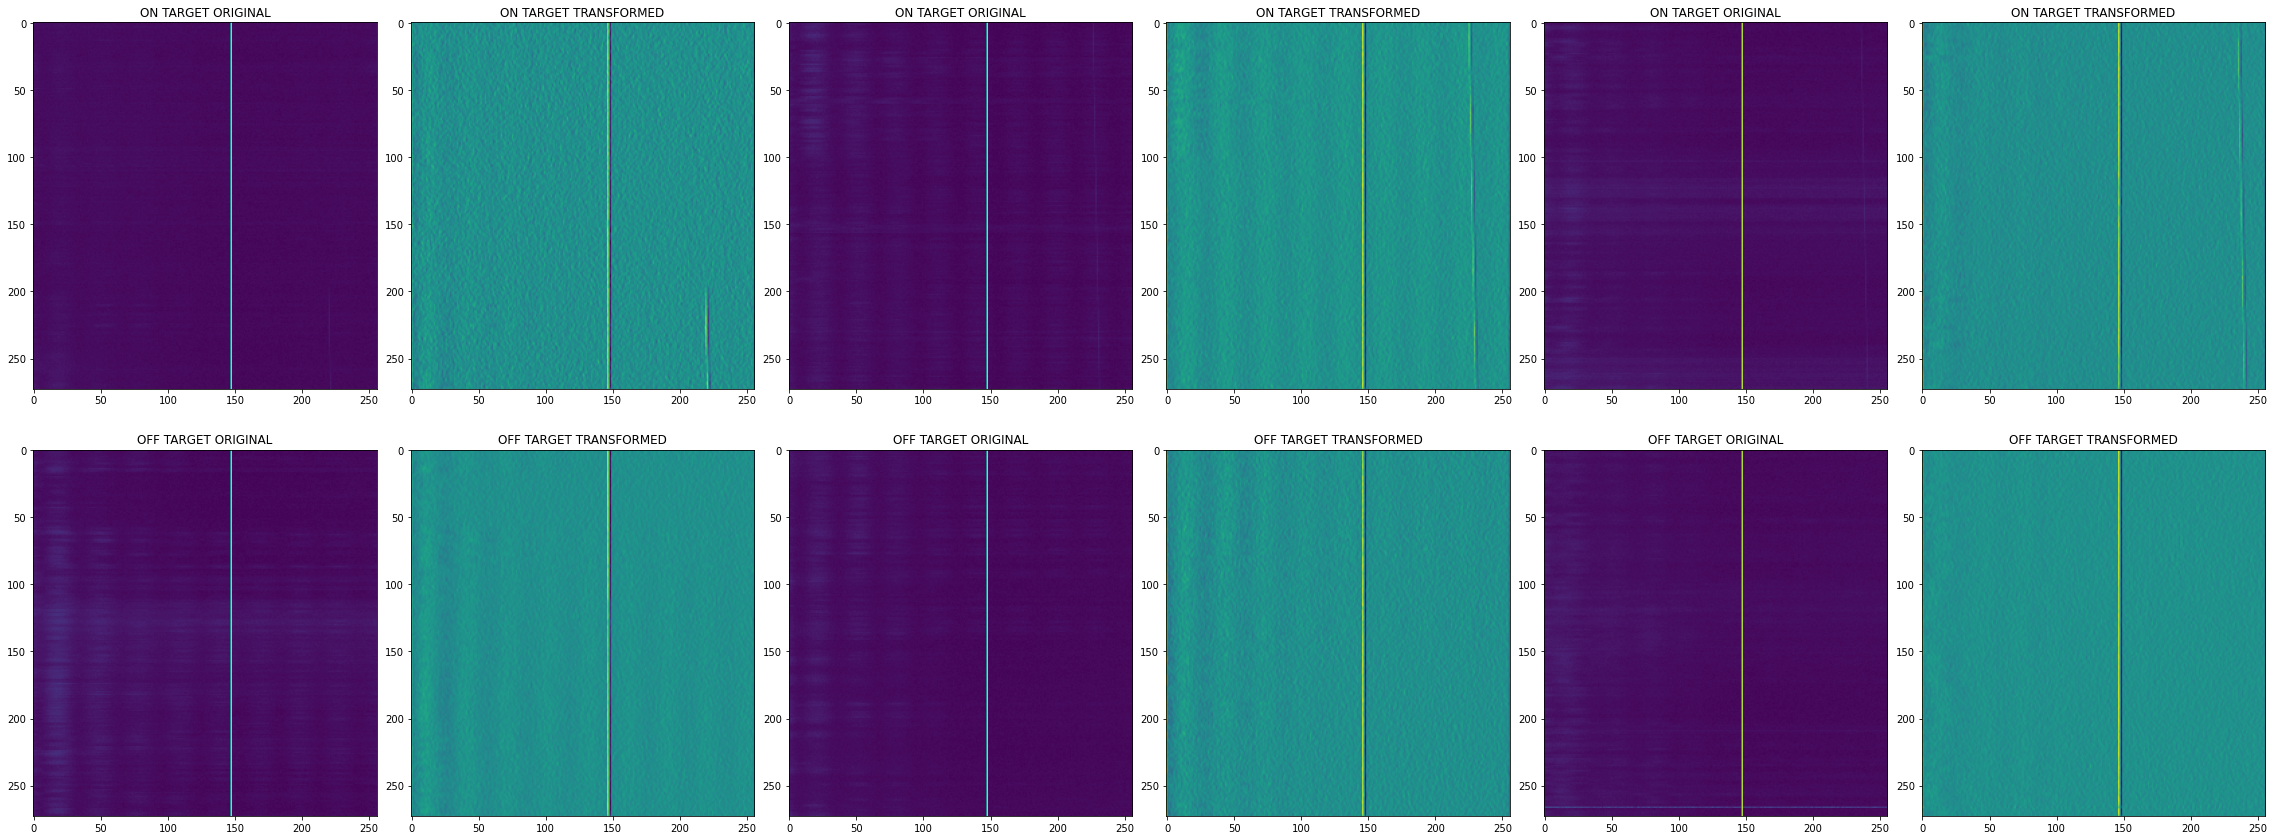

In [339]:
snake = "./train/0/002efdabe4e3e45.npy"
noisy = "./train/0/0028a35de92941d.npy"
very_low_signal = "./train/0/0347524a518ad36.npy"
signal_in_noisy_area = "./train/0/050b3f55c7d7ff4.npy"
very_low_signal_2 = "./train/0/0653719867ec6cd.npy"
hard_to_see = "./train/0/0024012d1431fbc.npy" # pretty hard to see in first on target on the right
hard_to_see_with_cv = "./train/0/00f129775fd7792.npy"
hard_to_see_with_cv_2 = "./train/0/00ffccd75595515.npy"
hard_to_see_with_cv_3 = "./train/0/010b8dc237f2d74.npy"
hard_to_see_with_cv_4 = "./train/0/0144b592dab0b64.npy"
hard_to_see_with_cv_5 = "./train/0/015caa134a91f8f.npy"
hard_to_see_with_cv_6 = "./train/0/01d30867493c1aa.npy"
hard_to_see_with_cv_7 = "./train/0/01fbbe7810f2f98.npy"
hard_to_see_with_cv_8 = "./train/0/0207f5b2147ec36.npy"
hard_to_see_with_cv_9 = "./train/0/02504e8ff8d3f66.npy"
hard_to_see_with_cv_10 = "./train/0/0252feb36ace15f.npy"
hard_to_see_with_cv_11 = "./train/0/027130b743b3925.npy"
hard_to_see_with_cv_12 = "./train/0/0282516e77f0b5a.npy"
hard_to_see_with_cv_13 = "./train/0/02919380c37fb34.npy"
hard_to_see_with_cv_14 = "./train/0/02b30cca710996e.npy"
hard_to_see_with_cv_15 = "./train/0/02d9cf5b3287634.npy"
for_improving_noisy_background = "./train/0/01949813672be23.npy"
for_improving_noisy_background_2 = "./train/0/01978740370eb8a.npy" # probably snakey lines in middle of on target pics
for_improving_blue_background = "./train/0/0185064f450d906.npy"
for_improving_blue_background_2 = "./train/0/0232f867b524219.npy"
for_improving_blue_background_3 = "./train/0/02f39b41f276683.npy"
test = "./train/0/032dd3aa6b1fe9a.npy"

test_cadence = Cadence(test)
time_1 = perf_counter()
# test_cadence.convolution_filter(filter_gauss)
time_2 = perf_counter()
# test_cadence.unify_similar_pixels(3) # reduces noise
# test_cadence.unify_similar_pixels(0.3) # reduces noise
time_3 = perf_counter()
test_cadence.map_similar_to_one() # reduces noise
time_4 = perf_counter()
test_cadence.map_to_proportional_colorscale() # reduces noise
time_5 = perf_counter()
test_cadence.convolution_filter(filter_x_sobel)
time_6 = perf_counter()
# test_cadence.convolution_filter(filter_gauss)
time_7 = perf_counter()
print("gauss: ", time_2 - time_1)
print("unify: ", time_3 - time_2)
print("mapsimilartoone: ", time_4 - time_3)
print("proportionalscale: ", time_5 - time_4)
print("sobel: ", time_6 - time_5)
print("gauss2: ", time_7 - time_6)

test_cadence.plot_cadence_for_comparing_differences()

In [340]:
# TOOD: was bedeuten diese komischen Zahlen